This is the competition: https://www.hackerearth.com/challenges/competitive/hackerearth-machine-learning-challenge-predict-the-lowest-price/leaderboard/predict-the-lowest-price-8-9ffabe00/

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
from collections import Counter
from statistics import mode
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from scipy import stats
import datetime as dt


Data wrangling 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,Item_Id,Date,State_of_Country,Market_Category,Product_Category,Grade,Demand,Low_Cap_Price,High_Cap_Price
0,IT_1,2007-07-05,0,0,0,0,0.5,2785,4240
1,IT_2,2007-07-05,0,1,0,0,0.7,3574,4756
2,IT_3,2007-07-05,0,103,0,1,1.6,5978,9669
3,IT_4,2007-07-05,0,103,0,0,0.0,5681,8313
4,IT_5,2007-07-05,0,103,0,2,0.0,4924,7257


In [4]:
train.shape

(9798, 9)

In [5]:
test.head()

,Item_Id,Date,State_of_Country,Market_Category,Product_Category,Grade,Demand,High_Cap_Price
0,IT_265079,2014-01-19,0,3,0,0,0.1,5303
1,IT_265087,2014-01-19,0,268,0,2,1.4,10492
2,IT_265107,2014-01-19,0,320,0,0,13.4,24706
3,IT_265139,2014-01-19,17,358,0,3,5.5,23464
4,IT_265142,2014-01-19,18,23,5,2,0.0,6222


In [6]:
test.shape

(5763, 8)

In [7]:
train.describe(include=['object'])

,Item_Id,Date
count,9798,9798
unique,9798,1070
top,IT_4898,2007-07-06
freq,1,44


Throughout the table shown, people would shop during the specific period, so time is a critical factor. Now, we can either perform a time-series or regression model. I choose to take advantage of the regression model since it is easy to understand. As long as we decide to include time in our regression model, we have to convert time into other types so that we can apply it in our model.

In [8]:
#date>num for train
train['Num_Date'] = pd.to_datetime(train['Date'])
train['Num_Date']=train['Num_Date'].map(dt.datetime.toordinal)

In [9]:
import datetime as dt

#month/year/day transform
train['Date'] = pd.to_datetime(train['Date'])
train.set_index('Date', inplace=True)
train.sort_index(inplace=True)
train['month'] = train.index.month
train['year'] = train.index.year
train['day'] = train.index.day
train.head()


,Item_Id,State_of_Country,Market_Category,Product_Category,Grade,Demand,Low_Cap_Price,High_Cap_Price,Num_Date,month,year,day
Date,,,,,,,,,,,,
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,2007,5
2007-07-05,IT_2,0,1,0,0,0.7,3574,4756,732862,7,2007,5
2007-07-05,IT_3,0,103,0,1,1.6,5978,9669,732862,7,2007,5
2007-07-05,IT_4,0,103,0,0,0.0,5681,8313,732862,7,2007,5
2007-07-05,IT_5,0,103,0,2,0.0,4924,7257,732862,7,2007,5


In [10]:
train.describe()

,State_of_Country,Market_Category,Product_Category,Grade,Demand,Low_Cap_Price,High_Cap_Price,Num_Date,month,year,day
count,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000,9798.000000
mean,14.278730,198.414064,2.492958,0.652072,71.977414,3500.273525,6349.838028,733316.725148,6.051439,2008.292202,15.560523
std,8.760964,169.767862,4.751807,1.032439,927.194052,2188.046803,3652.780956,310.892109,3.306099,0.938576,8.680330
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,163.000000,732862.000000,1.000000,2007.000000,1.000000
25%,3.000000,55.000000,0.000000,0.000000,0.500000,1863.250000,3878.250000,733072.000000,3.000000,2008.000000,8.000000
50%,20.000000,129.000000,0.000000,0.000000,2.000000,3124.000000,5552.500000,733258.000000,6.000000,2008.000000,15.000000
75%,21.000000,389.000000,1.000000,2.000000,10.175000,4667.500000,7993.750000,733567.000000,9.000000,2009.000000,23.000000
max,23.000000,471.000000,17.000000,3.000000,64160.500000,17580.000000,58812.000000,733932.000000,12.000000,2010.000000,31.000000


Demand can be categorized since it seems relevant to our topics.  Also, we need to delete the outlier! How to define low, medium, high demands? to fit what the context mentioned, like particular goods are needed when the price is low

In [11]:
train["Demand"].sort_values(ascending=False)
k=train[train.Demand<10]
k["Demand"].value_counts()

0.0    825
0.2    522
0.1    483
0.6    400
1.2    289
      ... 
7.4      8
7.6      6
7.5      5
9.9      4
8.8      4
Name: Demand, Length: 100, dtype: int64

In [12]:
bins = [0, 3, 500, 25000]

In [13]:
group_names = ['Low','Medium','High']
train['Demand-binned'] = pd.cut(train['Demand'], bins, labels=group_names, include_lowest=True )


train['Demand-binned'].value_counts()


Low       5737
Medium    3862
High       196
Name: Demand-binned, dtype: int64

In [14]:
#Grade can be categroied too.
train['Grade_Obj']=train["Grade"]
k=pd.get_dummies(train['Grade_Obj'],prefix="Grade")
train=train.join(k)
train.head()

,Item_Id,State_of_Country,Market_Category,Product_Category,Grade,Demand,Low_Cap_Price,High_Cap_Price,Num_Date,month,year,day,Demand-binned,Grade_Obj,Grade_0,Grade_1,Grade_2,Grade_3
Date,,,,,,,,,,,,,,,,,,
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,2007,5,Low,0,1,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,2007,5,Low,0,1,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,2007,5,Low,0,0,1,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,2007,5,Low,0,1,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,2007,5,Low,0,0,0,1,0


We can try product category.

In [15]:
train["Product_Category"].value_counts()

0     83866
10    12781
1      6619
13     4456
12     3062
15     2209
11      996
16      917
14      710
7       565
6       426
5       330
3       139
4        62
17       48
8        35
9        19
Name: Product_Category, dtype: int64

We can try Market, too.

In [16]:
train["Market_Category"].value_counts()
train["Market_Category_Obj"]=train["Market_Category"].astype(object)
train["State_of_Country_Obj"]=train["State_of_Country"].astype(object)
train["Product_Category_Obj"]=train["Product_Category"].astype(object)
train['Grade_Obj']=train['Grade_Obj'].astype(object)
train.head()

,Item_Id,State_of_Country,Market_Category,Product_Category,Grade,Demand,Low_Cap_Price,High_Cap_Price,Num_Date,month,...,day,Demand-binned,Grade_Obj,Grade_0,Grade_1,Grade_2,Grade_3,Market_Category_Obj,State_of_Country_Obj,Product_Category_Obj
Date,,,,,,,,,,,,,,,,,,,,,
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,0,1,0,0,0,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,0,1,0,0,0,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,0,0,1,0,0,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,0,1,0,0,0,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,0,0,0,1,0,0,0,0


In [17]:
# grouping results for demand vs. market_cate
train_test = train[['Demand-binned','Market_Category_Obj','Low_Cap_Price']]
grouped_test1 = train_test.groupby(['Demand-binned','Market_Category_Obj'],as_index=False).mean()
grouped_test1

,Demand-binned,Market_Category_Obj,Low_Cap_Price
0,Low,0,3044.797386
1,Low,1,2315.226238
2,Low,2,4601.517730
3,Low,3,2164.615071
4,Low,4,1025.000000
...,...,...,...
820,High,467,NaN
821,High,468,NaN
822,High,469,NaN
823,High,470,NaN


In [18]:
grouped_pivot = grouped_test1.pivot(index='Demand-binned',columns='Market_Category_Obj')
grouped_pivot

Low_Cap_Price                                         \
Market_Category_Obj           0            1            2            3     
Demand-binned                                                              
Low                   3044.797386  2315.226238  4601.517730  2164.615071   
Medium                2206.128713  1014.981283  4363.112179  1836.000000   
High                          NaN          NaN          NaN          NaN   

                                                                            \
Market_Category_Obj     4            6            7       8            9     
Demand-binned                                                                
Low                  1025.0  3052.905263  1346.512821  2779.0  5384.927711   
Medium                  NaN          NaN          NaN     NaN          NaN   
High                    NaN          NaN          NaN     NaN          NaN   

                                ...                                         \
Market_Category_Obj        10   ...          461          462          463   
Demand-binned                   ...                                          
Low                        NaN  ...  2654.341772  2972.288462  2051.770492   
Medium               748.47807  ...  1635.000000  1808.871658  1571.000000   
High                       NaN  ...          NaN          NaN          NaN   

                                                                           \
Market_Category_Obj     464     465          467         468          469   
Demand-binned                                                               
Low                  2323.0  3109.0  4244.467742  4020.03125  4476.962073   
Medium                  NaN     NaN  1153.000000         NaN  3737.993576   
High                    NaN     NaN          NaN         NaN          NaN   

                                               
Market_Category_Obj          470          471  
Demand-binned                                  
Low                  2582.589372  2298.830986  
Medium                       NaN  2214.026071  
High                         NaN          NaN  

[3 rows x 275 columns]

In [19]:
train.head(5)

,Item_Id,State_of_Country,Market_Category,Product_Category,Grade,Demand,Low_Cap_Price,High_Cap_Price,Num_Date,month,...,day,Demand-binned,Grade_Obj,Grade_0,Grade_1,Grade_2,Grade_3,Market_Category_Obj,State_of_Country_Obj,Product_Category_Obj
Date,,,,,,,,,,,,,,,,,,,,,
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,0,1,0,0,0,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,0,1,0,0,0,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,0,0,1,0,0,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,0,1,0,0,0,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,0,0,0,1,0,0,0,0


EDA

In [20]:
train.dtypes

Item_Id                   object
State_of_Country           int64
Market_Category            int64
Product_Category           int64
Grade                      int64
Demand                   float64
Low_Cap_Price              int64
High_Cap_Price             int64
Num_Date                   int64
month                      int64
year                       int64
day                        int64
Demand-binned           category
Grade_Obj                 object
Grade_0                    uint8
Grade_1                    uint8
Grade_2                    uint8
Grade_3                    uint8
Market_Category_Obj       object
State_of_Country_Obj      object
Product_Category_Obj      object
dtype: object

In [126]:
train["Grade"]=train["Demand"]/train["Grade"]

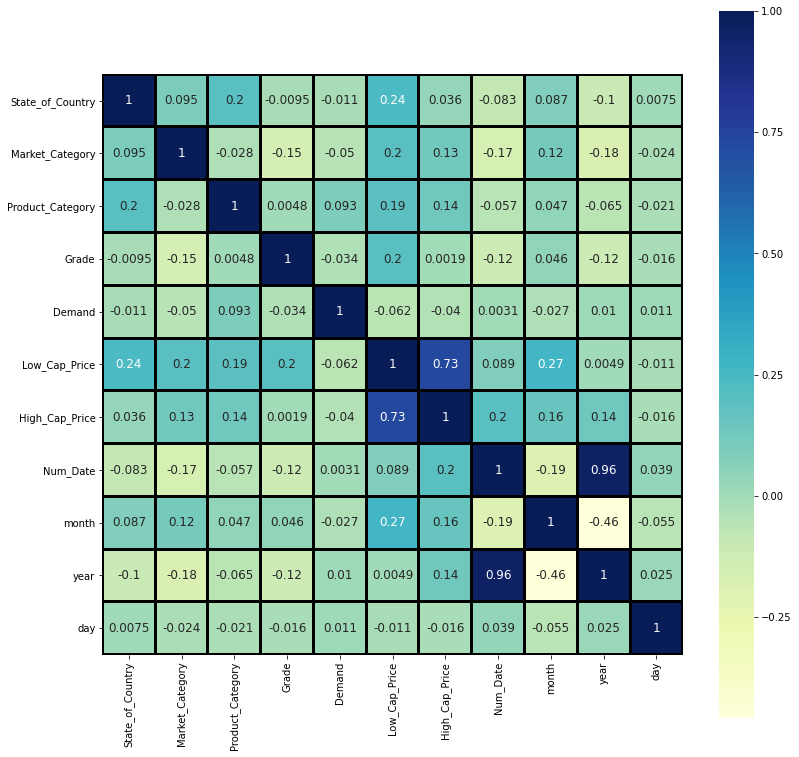

In [127]:
fig, axs = plt.subplots(nrows=1, figsize=(13, 13))
sns.heatmap(train.corr(), annot=True, square=True, cmap='YlGnBu', linewidths=2, linecolor='black', annot_kws={'size':12})

Based on the figures above, there are a few tests we need to perform to obtain the important variables.
Categorical: Grade,Demand,Market,State,Product>>ANOVA 
Numerous:High_cap_price>>Pearson test
6 tests in total!

In [22]:
#High_price vs Low_price
pearson_coef, p_value = stats.pearsonr(train['Low_Cap_Price'], train['High_Cap_Price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  
# high price okay!

The Pearson Correlation Coefficient is 0.7284711303894023  with a P-value of P = 0.0


In [23]:
#Demand vs Low_price
grouped_test2=train[['Demand-binned', 'Low_Cap_Price']].groupby(['Demand-binned'])
grouped_test2.get_group('Low')['Low_Cap_Price']

# ANOVA
f_val, p_val = stats.f_oneway(grouped_test2.get_group('Low')['Low_Cap_Price'], grouped_test2.get_group('Medium')['Low_Cap_Price'],grouped_test2.get_group('High')['Low_Cap_Price'])
 
print( "ANOVA results: F=", f_val, ", P =", p_val) 

f_val1, p_val1 = stats.f_oneway(grouped_test2.get_group('Low')['Low_Cap_Price'], grouped_test2.get_group('Medium')['Low_Cap_Price'])
 
print( "ANOVA results: F=", f_val1, ", P =", p_val1) 
f_val2, p_val2 = stats.f_oneway(grouped_test2.get_group('Low')['Low_Cap_Price'], grouped_test2.get_group('High')['Low_Cap_Price'],grouped_test2.get_group('High')['Low_Cap_Price'])
 
print( "ANOVA results: F=", f_val2, ", P =", p_val2) 
f_val3, p_val3 = stats.f_oneway(grouped_test2.get_group('Low')['Low_Cap_Price'], grouped_test2.get_group('High')['Low_Cap_Price'],grouped_test2.get_group('High')['Low_Cap_Price'])
 
print( "ANOVA results: F=", f_val3, ", P =", p_val3) 
#Demand okay

ANOVA results: F= 745.7706909271534 , P = 1.43e-322
ANOVA results: F= 123.44822237873814 , P = 1.1507339417789936e-28
ANOVA results: F= 1330.4191445677845 , P = 0.0
ANOVA results: F= 1330.4191445677845 , P = 0.0


In [24]:
train["Grade_Obj"].value_counts()

0    79483
2    20606
3     9342
1     7809
Name: Grade_Obj, dtype: int64

In [25]:
#Grade vs Low_price

bins = [-1, 0.5, 1.5, 2.2, 3.3]
group_names = ['Low','Medium_lower','Medium_higher','High']
train['Grade_Obj'] = pd.cut(train['Grade'], bins, labels=group_names, include_lowest=True )
grouped_test2=train[['Grade_Obj', 'Low_Cap_Price']].groupby(['Grade_Obj'])

# ANOVA
f_val4, p_val4 = stats.f_oneway(grouped_test2.get_group('Low')['Low_Cap_Price'], grouped_test2.get_group('Medium_lower')['Low_Cap_Price'],grouped_test2.get_group('Medium_higher')['Low_Cap_Price'],grouped_test2.get_group('High')['Low_Cap_Price'])
 
print( "ANOVA results: F=", f_val4, ", P =", p_val4) 

#Grade okay!

ANOVA results: F= 962.9872198385043 , P = 0.0


Based on the above tests, we know that High price, Demand, Datetime, and Grade are crucial factors; we, therefore, try to apply
a regression model by using those variables to see what the result could be. Why not State_of_Country, Product_cat, and Market_cat? This is because the person correlation is not so high, and the number of each category is not well distributed. 

In [26]:
train.head()

,Item_Id,State_of_Country,Market_Category,Product_Category,Grade,Demand,Low_Cap_Price,High_Cap_Price,Num_Date,month,...,day,Demand-binned,Grade_Obj,Grade_0,Grade_1,Grade_2,Grade_3,Market_Category_Obj,State_of_Country_Obj,Product_Category_Obj
Date,,,,,,,,,,,,,,,,,,,,,
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,Low,1,0,0,0,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,Low,1,0,0,0,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,Low,0,1,0,0,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,Low,1,0,0,0,0,0,0
2007-07-05,IT_1,0,0,0,0,0.5,2785,4240,732862,7,...,5,Low,Low,0,0,1,0,0,0,0


Modeling

In [27]:
from sklearn.linear_model import LinearRegression

i=train.drop(['Item_Id','Demand-binned', 'Grade_Obj', 'Grade_0', 'Grade_1',
       'Grade_2', 'Grade_3', 'Market_Category_Obj', 'State_of_Country_Obj',
       'Product_Category_Obj','Low_Cap_Price','State_of_Country','Market_Category','Product_Category'], axis=1)

model_1=LinearRegression()
model_1.fit(i,train.Low_Cap_Price)
print(model_1.score(i,train.Low_Cap_Price))
print(cross_val_score(model_1,i,train.Low_Cap_Price,cv=5).mean())

# It shows that this model is too bad to use.
# So let's include other three variables that we didn't include at the first place.

0.5995614747814569
0.5499422628987085


In [28]:
i2=train.drop(['Item_Id','Demand-binned', 'Grade_Obj', 'Grade_0', 'Grade_1',
       'Grade_2', 'Grade_3', 'Market_Category_Obj', 'State_of_Country_Obj',
       'Product_Category_Obj','Low_Cap_Price'], axis=1)

model_2=LinearRegression()
model_2.fit(i2,train.Low_Cap_Price)
print(model_2.score(i2,train.Low_Cap_Price))
print(cross_val_score(model_2,i2,train.Low_Cap_Price,cv=5).mean())
# Though the performance of the model is better than before, it is still not applicable.

0.6398200287059193
0.5951395931819647


In terms of the performance of models, we decide to adopt other models! First, I have to delete the redundant variables I coined for EDA.

In [29]:
train=train.drop(['Item_Id','Demand-binned', 'Grade_Obj', 'Grade_0', 'Grade_1',
       'Grade_2', 'Grade_3', 'Market_Category_Obj', 'State_of_Country_Obj',
       'Product_Category_Obj'], axis=1)

In [30]:
p=train.drop(['Low_Cap_Price'], axis=1)

In [31]:
p.reset_index(inplace=True) # Resets the index, makes factor a column
p.drop("Date",axis=1,inplace=True) # drop factor from axis 1 and make changes permanent by inplace=True

In [32]:
p.shape
p=p.drop_duplicates()

In [33]:
#Test should have the same dimension of data as train.
#date>num for train
test['Num_Date'] = pd.to_datetime(test['Date'])
test['Num_Date']=test['Num_Date'].map(dt.datetime.toordinal)

In [34]:
#month/year/day transform for test
test['Date'] = pd.to_datetime(test['Date'])
test.set_index('Date', inplace=True)
test.sort_index(inplace=True)
test['month'] = test.index.month
test['year'] = test.index.year
test['day'] = test.index.day
test.head()
j=test

In [35]:
j.reset_index(inplace=True) # Resets the index, makes factor a column
j.drop("Date",axis=1,inplace=True) # drop factor from axis 1 and make changes permanent by inplace=True

In [36]:
o=train
o.reset_index(inplace=True) # Resets the index, makes factor a column
o.drop("Date",axis=1,inplace=True) # drop factor from axis 1 and make changes permanent by inplace=True
o=o.drop_duplicates()
o.head()

,State_of_Country,Market_Category,Product_Category,Grade,Demand,Low_Cap_Price,High_Cap_Price,Num_Date,month,year,day
0,0,0,0,0,0.5,2785,4240,732862,7,2007,5
35,0,1,0,0,0.7,3574,4756,732862,7,2007,5
70,0,103,0,1,1.6,5978,9669,732862,7,2007,5
105,0,103,0,0,0.0,5681,8313,732862,7,2007,5
140,0,103,0,2,0.0,4924,7257,732862,7,2007,5


I'm going to run the multiple  models, and I then choose the best one.

In [37]:
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor()
model.fit(p,o.Low_Cap_Price)
new_test=j.drop(['Item_Id'], axis=1)
y_test=model.predict(new_test)
print(model.score(p,o.Low_Cap_Price))
print(cross_val_score(model,p,o.Low_Cap_Price,cv=5).mean())

0.9745459720908364
0.7210029090127877


In [38]:
from sklearn.ensemble import GradientBoostingRegressor


model2=GradientBoostingRegressor()
model2.fit(p,o.Low_Cap_Price)
y_test2=model2.predict(new_test)
print(model2.score(p,o.Low_Cap_Price))
print(cross_val_score(model2,p,o.Low_Cap_Price,cv=5).mean())


0.8536946461691326
0.7465061193229806


In [39]:
from sklearn.linear_model import LinearRegression
model3=LinearRegression()
model3.fit(p,o.Low_Cap_Price)
y_test3=model3.predict(new_test)
print(model3.score(p,o.Low_Cap_Price))
print(cross_val_score(model3,p,o.Low_Cap_Price,cv=5).mean())


0.630046029206427
0.6022321066462595


In [40]:
from sklearn.neighbors import KNeighborsClassifier
model4=KNeighborsClassifier(n_neighbors=5)
model4.fit(p,o.Low_Cap_Price)
y_test4=model4.predict(new_test)
print(model4.score(p,o.Low_Cap_Price))
print(cross_val_score(model4,p,o.Low_Cap_Price,cv=5).mean())

0.20789957134109002
0.0011310633489752442


In [41]:
from sklearn.neighbors import KNeighborsRegressor
model5=KNeighborsClassifier(n_neighbors=5)
model5.fit(p,o.Low_Cap_Price)
y_test5=model5.predict(new_test)
print(model5.score(p,o.Low_Cap_Price))
print(cross_val_score(model5,p,o.Low_Cap_Price,cv=5).mean())

0.20789957134109002
0.0011310633489752442


In [42]:
from xgboost import XGBRegressor

model6 = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
model6.fit(p,o.Low_Cap_Price)
# make predictions
predictions = model6.predict(new_test)
print(model6.score(p,o.Low_Cap_Price))
print(cross_val_score(model6,p,o.Low_Cap_Price,cv=5).mean())

0.9734798949116223
0.7229286189400638


In [43]:
p_1=p.drop(['State_of_Country','Market_Category','Product_Category'], axis=1)
model7=LinearRegression()
model7.fit(p_1,o.Low_Cap_Price)
g=new_test.drop(['State_of_Country','Market_Category','Product_Category'], axis=1)
y_test7=model7.predict(g)
print(model7.score(p_1,o.Low_Cap_Price))
print(cross_val_score(model7,p_1,o.Low_Cap_Price,cv=5).mean())

0.5911300243906659
0.5736443578067233


In conclusion, model2 is the best model because it doesn't overfit, and the score is the highest. That is, gradient boosting regressor has the best performance, so we decide to use this model! Based on the model, I wonder if I can gain better results by changing the variables(Backward selection). Then, I put in the grading system of Hackton.

In [121]:
p_1=p.drop(['Num_Date'], axis=1)
model8=GradientBoostingRegressor()
model8.fit(p_1,o.Low_Cap_Price)
g=new_test.drop(['Num_Date'], axis=1)
y_test8=model8.predict(g)
print(model8.score(p_1,o.Low_Cap_Price))
print(cross_val_score(model8,p_1,o.Low_Cap_Price,cv=5).mean())

0.8502547954145062
0.7487316553076491


In [196]:
p_1=p.drop(["Num_Date","year","Market_Category"], axis=1)
p_1["Grade"]=p_1["Demand"]/p_1["Grade"]
p_1["Demand"]=np.log(p_1["Demand"])
p_1=p_1.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
model9=GradientBoostingRegressor(random_state=0,learning_rate=0.2)
model9.fit(p_1,o.Low_Cap_Price)
g1=new_test.drop(["Num_Date","year",'Market_Category'], axis=1)
g1["Grade"]=g1["Demand"]/g1["Grade"]
g1["Demand"]=np.log(g1["Demand"])
g1=g1.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
y_test9=model9.predict(g1)
print(model9.score(p_1,o.Low_Cap_Price))
print(cross_val_score(model9,p_1,o.Low_Cap_Price,cv=5).mean())

0.8497955517566558
0.7402793056790078


In [189]:
g1.describe()

,State_of_Country,Market_Category,Product_Category,High_Cap_Price,month,day
count,5763.000000,5763.000000,5763.000000,5.763000e+03,5763.000000,5763.000000
mean,15.926080,222.169356,4.547978,3.732109e+04,5.884435,16.100816
std,8.122655,145.683245,5.485450,1.998985e+06,3.114528,8.764876
min,0.000000,0.000000,0.000000,1.000000e+00,1.000000,1.000000
25%,11.500000,65.000000,0.000000,7.244000e+03,3.000000,9.000000
50%,21.000000,238.000000,1.000000,9.364000e+03,6.000000,16.000000
75%,21.000000,340.000000,10.000000,1.256250e+04,8.000000,24.000000
max,23.000000,471.000000,17.000000,1.517609e+08,12.000000,31.000000


In conclusion, model9 is the best predictor until now

In [190]:
test["Low_Cap_Price"]=pd.DataFrame(data=y_test9)
test["Low_Cap_Price"]=test["Low_Cap_Price"].astype(int)

In [191]:
test.head()

,Item_Id,State_of_Country,Market_Category,Product_Category,Grade,Demand,High_Cap_Price,Num_Date,month,year,day,Low_Cap_Price
0,IT_265079,0,3,0,0,0.1,5303,735252,1,2014,19,2556
1,IT_265087,0,268,0,2,1.4,10492,735252,1,2014,19,2781
2,IT_265107,0,320,0,0,13.4,24706,735252,1,2014,19,5016
3,IT_265139,17,358,0,3,5.5,23464,735252,1,2014,19,11422
4,IT_265142,18,23,5,2,0.0,6222,735252,1,2014,19,2253


In [192]:
test.describe()

,State_of_Country,Market_Category,Product_Category,Grade,Demand,High_Cap_Price,Num_Date,month,year,day,Low_Cap_Price
count,5763.000000,5763.000000,5763.000000,5763.00000,5763.000000,5.763000e+03,5763.000000,5763.000000,5763.000000,5763.000000,5763.000000
mean,15.926080,222.169356,4.547978,0.39823,67.695471,3.732109e+04,735564.640118,5.884435,2014.459830,16.100816,5528.041124
std,8.122655,145.683245,5.485450,0.81668,486.501858,1.998985e+06,186.277615,3.114528,0.498427,8.764876,2623.823411
min,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000e+00,735252.000000,1.000000,2014.000000,1.000000,139.000000
25%,11.500000,65.000000,0.000000,0.00000,0.600000,7.244000e+03,735399.000000,3.000000,2014.000000,9.000000,3902.000000
50%,21.000000,238.000000,1.000000,0.00000,2.300000,9.364000e+03,735571.000000,6.000000,2014.000000,16.000000,5337.000000
75%,21.000000,340.000000,10.000000,0.00000,8.400000,1.256250e+04,735730.500000,8.000000,2015.000000,24.000000,6818.000000
max,23.000000,471.000000,17.000000,3.00000,13242.600000,1.517609e+08,735870.000000,12.000000,2015.000000,31.000000,17147.000000


In [193]:
submission = pd.DataFrame({'Item_Id':test['Item_Id'],'Low_Cap_Price':test["Low_Cap_Price"]})
submission.to_csv('predict_the_lowest_price35.csv',index=False)